In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data
    
    def secondOrder(self):
        for col in self.data:
            self.data[col+'(t-1)'] = self.data[col].shift(1)
        self.data = self.data.dropna()
        return self.data

In [3]:
training = ProcessingData("../../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.drop_nan()
#training_data.head()

In [4]:
testing = ProcessingData("../../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.drop_nan()
#testing_data.head()

In [5]:
train_y = training_data['t_next']
train_X = training_data.drop(['t_next'], axis=1)
train_X.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-04-18 23:16:42+00:00,69.483333,66.499700,0.0,0,0
2018-04-18 23:21:42+00:00,69.500000,66.499700,0.0,0,0
2018-04-18 23:26:42+00:00,69.500000,66.520546,0.0,0,0
2018-04-18 23:31:42+00:00,69.500000,66.583083,0.0,0,0
2018-04-18 23:36:42+00:00,69.400000,66.666466,0.0,0,0


In [6]:
test_y = testing_data['t_next']
test_X = testing_data.drop(['t_next'], axis=1)
#test_X.head()

In [7]:
from sklearn.linear_model import LinearRegression

def linearRegression(train_X, train_y,test_X,test_y):
    linearModel = LinearRegression().fit(train_X, train_y)
    test_pred = linearModel.predict(test_X)
    rmse = sqrt(mean_squared_error(test_y,test_pred))
    print(rmse)
    return linearModel

In [8]:
from sklearn import linear_model

def lassoRegression(train_X, train_y,test_X,test_y):
    lasso_clf = linear_model.Lasso(alpha=0.1)
    lasso_clf.fit(train_X, train_y)
    test_pred = lasso_clf.predict(test_X)
    rmse = sqrt(mean_squared_error(test_y,test_pred))
    print(rmse)
    return lasso_clf

In [9]:
from sklearn.linear_model import Ridge

def ridgeRegression(train_X, train_y,test_X,test_y):
    ridge_clf = Ridge(alpha=1.0)
    ridge_clf.fit(train_X, train_y)
    test_pred = ridge_clf.predict(test_X)
    rmse = sqrt(mean_squared_error(test_y,test_pred))
    print(rmse)
    return ridge_clf

In [10]:
linearModel = linearRegression(train_X,train_y, test_X, test_y)
lassoModel = lassoRegression(train_X, train_y, test_X, test_y)
ridgeModel = ridgeRegression(train_X,train_y, test_X, test_y)

0.8619954953985445
0.8593494185379873
0.8619931664638767


In [11]:
class PrincipalComponentAnalysis:
    def __init__(self, trainX, trainY, testX, testY):
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
    
    def scaleAndPca(self):
        self.scaler = StandardScaler()
        self.scaler.fit(self.trainX)
        train_scaled = self.scaler.transform(self.trainX)
        test_scaled = self.scaler.transform(self.testX)

        self.pca = PCA(0.95)
        self.pca.fit(train_scaled)
        train_pca = self.pca.transform(train_scaled)
        test_pca = self.pca.transform(test_scaled)

        #print(train_pca.shape)
        #print(train_y)
        self.pcaLinearModel = linearRegression(train_pca,self.trainY, test_pca, self.testY)
    
        return self



In [12]:
second_training = ProcessingData("../../Data/avenal-animal-shelter_training_data.pkl")
second_training_data = second_training.fix_data(5)
second_training_data = second_training.filter_data()
second_training_data = second_training.secondOrder()
second_training_data = second_training.drop_nan()
second_train_y = second_training_data['t_next']
second_train_X = second_training_data.drop(['t_next', 't_next(t-1)'], axis=1)

second_testing = ProcessingData("../../Data/avenal-animal-shelter_test_data.pkl")
second_testing_data = second_testing.fix_data(5)
second_testing_data = second_testing.filter_data()
second_testing_data = second_testing.secondOrder()
second_testing_data = second_testing.drop_nan()
second_test_y = second_testing_data['t_next']
second_test_X = second_testing_data.drop(['t_next', 't_next(t-1)'], axis=1)

second_linearModel = linearRegression(second_train_X,second_train_y, second_test_X, second_test_y)
second_lassoModel = lassoRegression(second_train_X,second_train_y, second_test_X, second_test_y)
second_ridgeModel = ridgeRegression(second_train_X,second_train_y, second_test_X, second_test_y)

0.8669073691700774
0.8593815125721489
0.8666426782247197


In [13]:
pcaObjHandler1 = PrincipalComponentAnalysis(train_X, train_y, test_X, test_y)
pcaObj = pcaObjHandler1.scaleAndPca()

pcaObjHandler2 = PrincipalComponentAnalysis(second_train_X,second_train_y, second_test_X, second_test_y)
second_pcaObj = pcaObjHandler2.scaleAndPca()

0.8619954953985456
0.7599748891618074


In [14]:
def scaling(data):
    maxValues = []
    scaled = np.empty([data.shape[0], data.shape[1]])
    numSamples = data.shape[0]
    numFeatures = data.shape[1]
    dataValues = data.values
    dataValues = dataValues.astype('float32')
    for i in range(numFeatures):
        maxNum = max(dataValues[:,i])
        maxValues.append(maxNum)
        for j in range(numSamples):
            scaled[j,i] = dataValues[j,i]/maxNum
    return scaled, maxValues

In [15]:
train_scaled, train_scalers = scaling(training_data)
train_scaled = pd.DataFrame(data=train_scaled, index=training_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling'])

test_scaled, test_scalers = scaling(testing_data)
test_scaled = pd.DataFrame(data=test_scaled, index=testing_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling'])

trainY_df = train_scaled['t_next']
trainX_df = train_scaled.drop(['t_next'], axis=1)

testY_df = test_scaled['t_next']
testX_df = test_scaled.drop(['t_next'], axis=1)

# split into input and outputs
train = train_scaled.values
test = test_scaled.values
lstm_train_X, lstm_train_y = train[:, 1:], train[:, 0]
lstm_test_X, lstm_test_y = test[:, 1:], test[:, 0]

lstm_train_X = lstm_train_X.reshape((lstm_train_X.shape[0], 1, 5))
lstm_test_X = lstm_test_X.reshape((lstm_test_X.shape[0], 1, 5))
print(lstm_train_X.shape, lstm_train_y.shape, lstm_test_X.shape, lstm_test_y.shape)

(53186, 1, 5) (53186,) (13390, 1, 5) (13390,)


In [16]:
second_lstm_training = ProcessingData("../../Data/avenal-animal-shelter_training_data.pkl")
second_lstm_training_data = second_lstm_training.fix_data(5)
second_lstm_training_data = second_lstm_training.filter_data()
second_lstm_training_data = second_lstm_training.secondOrder()
second_lstm_training_data = second_lstm_training.drop_nan()

second_lstm_testing = ProcessingData("../../Data/avenal-animal-shelter_test_data.pkl")
second_lstm_testing_data = second_lstm_testing.fix_data(5)
second_lstm_testing_data = second_lstm_testing.filter_data()
second_lstm_testing_data = second_lstm_testing.secondOrder()
second_lstm_testing_data = second_lstm_testing.drop_nan()

second_lstm_train_scaled, second_lstm_train_scalers = scaling(second_lstm_training_data)
second_lstm_train_scaled = pd.DataFrame(data=second_lstm_train_scaled, index=second_lstm_training_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling', 't_next(t-1)', 't_in(t-1)', 't_out(t-1)', 'occ(t-1)', 'action_heating(t-1)', 'action_cooling(t-1)'])
second_lstm_test_scaled, second_lstm_test_scalers = scaling(second_lstm_testing_data)
second_lstm_test_scaled = pd.DataFrame(data=second_lstm_test_scaled, index=second_lstm_testing_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling', 't_next(t-1)', 't_in(t-1)', 't_out(t-1)', 'occ(t-1)', 'action_heating(t-1)', 'action_cooling(t-1)'])

second_lstm_trainY_df = second_lstm_train_scaled['t_next']
second_lstm_trainX_df = second_lstm_train_scaled.drop(['t_next', 't_next(t-1)'], axis=1)
second_lstm_testY_df = second_lstm_test_scaled['t_next']
second_lstm_testX_df = second_lstm_test_scaled.drop(['t_next', 't_next(t-1)'], axis=1)

second_lstm_train_X = second_lstm_trainX_df.values
second_lstm_train_y = second_lstm_trainY_df.values
second_lstm_test_X = second_lstm_testX_df.values
second_lstm_test_y = second_lstm_testY_df.values
second_lstm_train_X = second_lstm_train_X.reshape((second_lstm_train_X.shape[0], 2, 5))
second_lstm_test_X = second_lstm_test_X.reshape((second_lstm_test_X.shape[0], 2, 5))


In [17]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [18]:
fileObject1 = open("lstmModel3.pickle", 'rb')  
lstmModel = pickle.load(fileObject1) 
fileObject2 = open("secondLstmModel1.pickle", 'rb') 
second_lstmModel = pickle.load(fileObject2) 

In [19]:
def forecasting(test_X, test_y, start_time, duration, model, second_order):
    predictions_i = []
    errs_i = []
    curr_time = start_time
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        if curr_time not in test_X.index:
            return None
        input_x = test_X.loc[curr_time].copy()
        if second_order == 1:
            if len(predictions_i) < 2:
                predictions_i.append(input_x['t_in'])
            else:
                input_x['t_in'] = predictions_i[-1]
                input_x['t_in(t-1)'] = predictions_i[-2]
        else:
            if predictions_i:
                input_x['t_in'] = predictions_i[-1]
        y = model.predict([input_x])
        predictions_i.append(y[0])
        errs_i.append(test_y.loc[curr_time] - y[0])
        curr_time = curr_time + datetime.timedelta(minutes=5)
    return errs_i

In [20]:
def forecastingPCA(testX, testY, start, duration, modelObj, second_order):
    predictions_i = []
    errs_i = []
    curr_time = start
    end_time = start + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        if curr_time not in testX.index:
            return None
        input_x = testX.loc[curr_time].copy()
        if second_order == 1:
            if len(predictions_i) < 2:
                predictions_i.append(input_x['t_in'])
            else:
                input_x['t_in'] = predictions_i[-1]
                input_x['t_in(t-1)'] = predictions_i[-2]
        else:
            if predictions_i:
                input_x['t_in'] = predictions_i[-1]
                
        input_x_values = input_x.values
        input_x_scaled = modelObj.scaler.transform(input_x_values.reshape(1,-1))
        input_x_pca = modelObj.pca.transform(input_x_scaled)
        
        y = modelObj.pcaLinearModel.predict(input_x_pca)
        predictions_i.append(y[0])
        errs_i.append(testY.loc[curr_time] - y[0])
        curr_time = curr_time + datetime.timedelta(minutes=5)
    return errs_i

In [21]:
def forecastingLSTM(testX_df, testY_df, start_time, duration, model, maxT_in, second_order):
    predictions_i = []
    errs_i = []
    curr_time = start_time
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        if curr_time not in testX_df.index:
            #print("Not present")
            return None
        input_x = testX_df.loc[curr_time].copy()
        if second_order == 1:
            if len(predictions_i) < 2:
                predictions_i.append(input_x['t_in'])
            else:
                input_x['t_in'] = predictions_i[-1]
                input_x['t_in(t-1)'] = predictions_i[-2]
            reshape_param = 2
        else:
            if predictions_i:
                input_x['t_in'] = predictions_i[-1]
            reshape_param = 1
        inputX_values = input_x.values
        inputX_values = inputX_values.reshape(1,reshape_param,5)
        y = model.predict([inputX_values])
        predictions_i.append(y[0][0])
        #print(y[0][0])
        errs_i.append(testY_df.loc[curr_time]*maxT_in - y[0][0]*maxT_in)
        curr_time = curr_time + datetime.timedelta(minutes=5)
    #print(predictions_i)
    #print(errs_i)
    return errs_i

In [22]:
def timeStepErrors(errs):
    errors = []
    for i in range(int(duration/5)):
            ei = np.array([])
            for e in errs:
                ei = np.append(ei, e.loc[i]*e.loc[i])
            errors.append(ei)
    return errors

def t_test(reg_errs, lstm_errs):
    t_values = []
    p_values = []
    reg_errors = timeStepErrors(reg_errs)
    lstm_errors = timeStepErrors(lstm_errs)
    for i in range(len(reg_errors)):
        t, p = stats.ttest_rel(reg_errors[i], lstm_errors[i])
        t_values.append(t)
        p_values.append(p)
    return t_values, p_values

def getTimeStepErrors(testX, testY, startList, duration, model, maxT_in, method, second_order=0):
    errs = []
    if method == "lstm":
        for start in startList:
            errs_i = forecastingLSTM(testX, testY, start, duration, model, maxT_in, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    elif method == "regression":
        for start in startList:
            errs_i = forecasting(testX, testY, start, duration, model, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    elif method == "pca":
        for start in startList:
            errs_i = forecastingPCA(testX, testY, start, duration, model, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    #errors = timeStepErrors(errs)
    return errs


In [23]:
def getErrors(testX, testY, startList, duration, model, maxT_in, method, second_order=0):
    errs = []
    if method == "lstm":
        for start in startList:
            errs_i = forecastingLSTM(testX, testY, start, duration, model, maxT_in, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    elif method == "regression":
        for start in startList:
            errs_i = forecasting(testX, testY, start, duration, model, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    elif method == "pca":
        for start in startList:
            errs_i = forecastingPCA(testX, testY, start, duration, model, second_order)
            if errs_i:
                errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
    
    final_errors = []
    for i in range(int(duration/5)):
        ei = np.array([])
        for e in errs:
            ei = np.append(ei, e.loc[i]*e.loc[i])
        final_errors.append(sqrt(np.mean(ei)))
    return final_errors

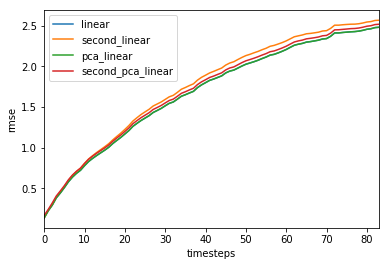

,linear,second_linear,pca_linear,second_pca_linear
0,0.136189,0.136729,0.136189,0.167988
1,0.224200,0.226429,0.224200,0.240500
2,0.293201,0.298188,0.293201,0.319684
3,0.382428,0.390178,0.382428,0.405844
4,0.442598,0.452255,0.442598,0.467872


In [24]:
startSamples = test_X.sample(n=800)
startList = startSamples.index
duration = 60 * 7
maxT_in = max(testing_data['t_in'])

df_errors = pd.DataFrame()

df_errors['linear'] = getErrors(test_X, test_y, startList, duration, linearModel,maxT_in, "regression")
df_errors['second_linear'] = getErrors(second_test_X, second_test_y, startList, duration, second_linearModel, maxT_in, "regression", 1)

df_errors['pca_linear'] = getErrors(test_X, test_y, startList, duration, pcaObj, maxT_in, "pca")
df_errors['second_pca_linear'] = getErrors(second_test_X, second_test_y, startList, duration, second_pcaObj, maxT_in, "pca", 1)


df_errors.plot()
plt.xlabel('timesteps')
plt.ylabel('rmse')
plt.show()
df_errors.head()

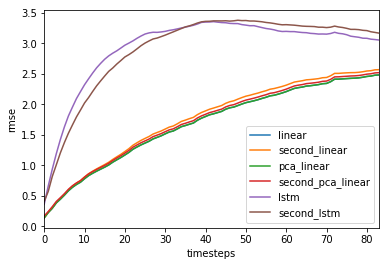

In [25]:
df_errors['lstm'] = getErrors(testX_df, testY_df, startList, duration, lstmModel, maxT_in, "lstm")
df_errors['second_lstm'] = getErrors(second_lstm_testX_df, second_lstm_testY_df, startList, duration, second_lstmModel, maxT_in, "lstm", 1)

df_errors.plot()
plt.xlabel('timesteps')
plt.ylabel('rmse')
plt.show()

C:\Users\Aishu\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\Aishu\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


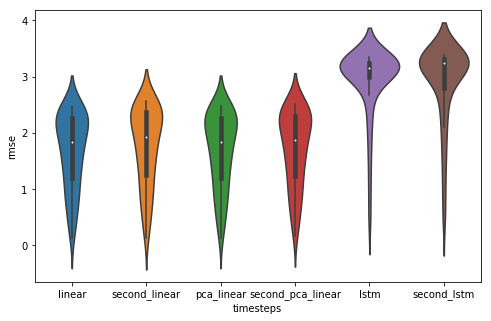

In [32]:
fig, ax = plt.subplots(figsize=(8,5))
sns.violinplot(ax=ax, data=df_errors)
plt.xlabel('timesteps')
plt.ylabel('rmse')
plt.show()

In [28]:
pca_reg2_errs = getTimeStepErrors(second_test_X, second_test_y, startList, duration, second_pcaObj, maxT_in, "pca", 1)
pca_reg1_errs =  getTimeStepErrors(test_X, test_y, startList, duration, pcaObj, maxT_in, "pca", 0)
t_values, p_values = t_test(pca_reg1_errs, pca_reg2_errs)
print("t:",t_values)
print("p:",p_values)

t: [-3.7407773787541196, -3.7431160079299204, -4.338307960141913, -4.4731041470505923, -4.4997769433540089, -4.5223425247935047, -4.7005760245810686, -4.9119832533527568, -4.8050262647627049, -4.7401602969086021, -4.7638668603992098, -4.7908534948673749, -4.668049129887299, -4.8816686666647318, -5.1692032802235079, -5.3937742485326146, -5.4059610404273366, -5.3504367936782318, -5.2620354438255701, -5.419918435346867, -5.3878680412724709, -5.3954943697552062, -5.3649395280617407, -5.3583770893375569, -5.2853893592595265, -5.1839654269441642, -5.0203804943580774, -4.8540514164566817, -4.8903913317130661, -5.0350241878542734, -5.1092937510613359, -5.0820334610296642, -4.92550773652101, -4.7594907209292803, -4.6907742574831568, -4.6258366720988189, -4.4934757513764865, -4.462152466718095, -4.4114237825002665, -4.4427118586038068, -4.4376937299276245, -4.4308438254019906, -4.4172813349833477, -4.4310780453344991, -4.4305146847205981, -4.399065488103858, -4.3831738693447768, -4.4067169010337

In [ ]:
reg2_errs = getTimeStepErrors(second_test_X, second_test_y, startList, duration, second_linearModel, maxT_in, "regression", 1)
reg1_errs =  getTimeStepErrors(test_X, test_y, startList, duration, linearModel, maxT_in, "regression", 0)       
t_values, p_values = t_test(reg1_errs, reg2_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(reg1_errs, pca_reg1_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(reg1_errs, pca_reg2_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(reg2_errs, pca_reg1_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(reg2_errs, pca_reg2_errs)
print("p:",p_values)

In [ ]:
lstm2_errs =  getTimeStepErrors(second_lstm_testX_df, second_lstm_testY_df, startList, duration, second_lstmModel, maxT_in, "lstm", 1)
lstm1_errs =  getTimeStepErrors(testX_df, testY_df, startList, duration, lstmModel, maxT_in, "lstm", 0)  
t_values, p_values = t_test(lstm1_errs, lstm2_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(reg1_errs, lstm1_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(reg1_errs, lstm2_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(reg2_errs, lstm1_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(reg2_errs, lstm2_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(pca_reg1_errs, lstm1_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(pca_reg1_errs, lstm2_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(pca_reg2_errs, lstm1_errs)
print("p:",p_values)

In [ ]:
t_values, p_values = t_test(pca_reg2_errs, lstm2_errs)
print("p:",p_values)

In [ ]:
sns.boxplot(data=df_errors)
plt.xlabel('timesteps')
plt.ylabel('rmse')
plt.show()

In [ ]:
df_errors['lasso'] = getErrors(test_X, test_y, startList, duration, lassoModel, maxT_in, "regression")
df_errors['ridge'] = getErrors(test_X, test_y, startList, duration, ridgeModel, maxT_in, "regression")

df_errors['second_lasso'] = getErrors(second_test_X, second_test_y, startList, duration, second_lassoModel, maxT_in, "regression", 1)
df_errors['second_ridge'] = getErrors(second_test_X, second_test_y, startList, duration, second_ridgeModel, maxT_in, "regression", 1)

df_errors.plot()
plt.show()

In [ ]:
sns.violinplot(data=df_errors)
plt.show()

In [ ]:
sns.boxplot(data=df_errors)
plt.show()

In [ ]:
sns.regplot(x=df_errors, y=df_errors.index, data=df_errors)